In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Requirements

In [33]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Reshape, Permute
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
import tqdm as tqdm
import cv2
import cv2 as cv
import time
from tensorflow.keras.utils import Sequence
from moviepy.editor import VideoFileClip, ImageSequenceClip

# Losses

In [34]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

def total_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    return loss

# Define U-Net model

In [35]:
def unet(num_classes, input_shape, lr_init, vgg_weight_path=None):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        vgg16 = Model(img_input, for_pretrained_weight)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # last conv
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=lr_init),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model

# Data

In [36]:
img_height, img_width = 256, 512
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [37]:
# Use only 3 classes.
labels = ['background', 'person', 'car', 'road']

In [38]:
from keras.preprocessing.image import ImageDataGenerator
def pre_processing(img):
    # Random exposure and saturation (0.9 ~ 1.1 scale)
    rand_s = random.uniform(0.9, 1.1)
    rand_v = random.uniform(0.9, 1.1)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    tmp = np.ones_like(img[:, :, 1]) * 255
    img[:, :, 1] = np.where(img[:, :, 1] * rand_s > 255, tmp, img[:, :, 1] * rand_s)
    img[:, :, 2] = np.where(img[:, :, 2] * rand_v > 255, tmp, img[:, :, 2] * rand_v)

    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    # Centering helps normalization image (-1 ~ 1 value)
    return img / 127.5 - 1

def get_data_gen_args(mode):
    if mode == 'train' or mode == 'val':
        x_data_gen_args = dict(preprocessing_function=pre_processing,
                               shear_range=0.1,
                               zoom_range=0.1,
                               rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               fill_mode='constant',
                               horizontal_flip=True)

        y_data_gen_args = dict(shear_range=0.1,
                               zoom_range=0.1,
                               rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               fill_mode='constant',
                               horizontal_flip=True)

    elif mode == 'test':
        x_data_gen_args = dict(preprocessing_function=pre_processing)
        y_data_gen_args = dict()

    else:
        print("Data_generator function should get mode arg 'train' or 'val' or 'test'.")
        return -1

    return x_data_gen_args, y_data_gen_args

# One hot encoding for y_img.
def get_result_map(b_size, y_img):
    y_img = np.squeeze(y_img, axis=3)
    result_map = np.zeros((b_size, 256, 512, 4))

    # For np.where calculation.
    person = (y_img == 24)
    car = (y_img == 26)
    road = (y_img == 7)
    background = np.logical_not(person + car + road)

    result_map[:, :, :, 0] = np.where(background, 1, 0)
    result_map[:, :, :, 1] = np.where(person, 1, 0)
    result_map[:, :, :, 2] = np.where(car, 1, 0)
    result_map[:, :, :, 3] = np.where(road, 1, 0)

    return result_map

# Data generator for fit_generator.
def data_generator(dataset, b_size, mode):

    x_imgs = dataset[0]
    y_imgs = dataset[1]

    # Make ImageDataGenerator.
    x_data_gen_args, y_data_gen_args = get_data_gen_args(mode)
    x_data_gen = ImageDataGenerator(**x_data_gen_args)
    y_data_gen = ImageDataGenerator(**y_data_gen_args)

    # random index for random data access.
    d_size = x_imgs.shape[0]
    shuffled_idx = list(range(d_size))

    x = []
    y = []
    while True:
        random.shuffle(shuffled_idx)
        for i in range(d_size):
            idx = shuffled_idx[i]

            x.append(x_imgs[idx].reshape((256, 512, 3)))
            y.append(y_imgs[idx].reshape((256, 512, 1)))

            if len(x) == b_size:
                # Adapt ImageDataGenerator flow method for data augmentation.
                _ = np.zeros(b_size)
                seed = random.randrange(1, 1000)

                x_tmp_gen = x_data_gen.flow(np.array(x), _,
                                            batch_size=b_size,
                                            seed=seed)
                y_tmp_gen = y_data_gen.flow(np.array(y), _,
                                            batch_size=b_size,
                                            seed=seed)

                # Finally, yield x, y data.
                x_result, _ = next(x_tmp_gen)
                y_result, _ = next(y_tmp_gen)

                yield x_result, get_result_map(b_size, y_result)

                x.clear()
                y.clear()

def load_data(lst_path_x, lst_path_y):
    images = []
    labels = []
    # i = 0
    # l = len(lst_path_x)
    for x,y in tqdm.tqdm(zip(lst_path_x, lst_path_y)):
        images.append(cv2.cvtColor(cv.resize(cv.imread(x),(512,256)), cv2.COLOR_BGR2RGB))

        y_img = cv.resize(cv.imread(y),(512,256))
        y_img = y_img[:, :, 0]
        labels.append(y_img)
        
    return np.asarray(images),np.asarray(labels)

# Train

In [39]:
!nvidia-smi

Mon Dec 27 19:07:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    58W / 149W |  11076MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dataset Kitti 

In [40]:
image_path = "/content/drive/MyDrive/Đồ án khmt/CS406/data_semantics/training/image_2/"
mask_path = "/content/drive/MyDrive/Đồ án khmt/CS406/data_semantics/training/semantic/"
  
lst_train_x = sorted([image_path + f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))])
lst_train_y = sorted([mask_path + f for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))])

print(len(lst_train_x),len(lst_train_y))

200 200


In [41]:
dataset = load_data(lst_train_x, lst_train_y)

200it [00:07, 28.04it/s]


## Visual example of dataset

<Figure size 720x720 with 0 Axes>

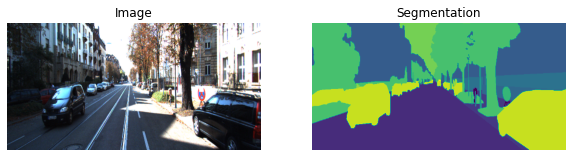

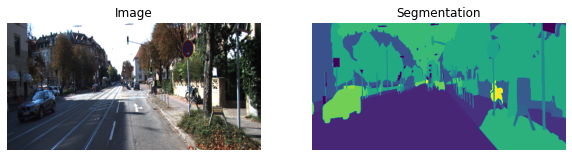

In [42]:
import matplotlib.pyplot as plt

idx = 0
plt.figure(figsize=(10, 10))
for images, lables in zip(dataset[0],  dataset[1]):
    fig, arr = plt.subplots(1, 2 , figsize=(10, 10))
    arr[0].imshow(images)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(lables)
    arr[1].set_title('Segmentation')
    arr[1].axis("off") 
    idx +=1
    if idx ==2:
      break

## Load pretrained model VGG16 offered by keras.

In [43]:
!gdown --id 152DjgAX7OzUYl1vnd94ofwOOxjpTg6-1

Downloading...
From: https://drive.google.com/uc?id=152DjgAX7OzUYl1vnd94ofwOOxjpTg6-1
To: /content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
100% 58.9M/58.9M [00:00<00:00, 126MB/s]


## Initialize parameter and callback

In [44]:
batch_size = 4 # Batch size for train.
val_batch = 1 # Batch size for validation.
lr_init = 1e-4 # Initial learning rate.
# lr_decay = 5e-4 # How much to decay the learning rate.
vgg_path = "/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5" # Pretrained vgg16 weight path.

callback = EarlyStopping(monitor='val_dice_coef', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
model_checkpoint = ModelCheckpoint('kitti-unet-semantic-model.h5', monitor='val_dice_coef',verbose=1, save_best_only=True)

In [45]:
# Use only 3 classes.
labels = ['background', 'person', 'car', 'road']

## Initialize model Unet with VGG 16 pretrained

In [46]:
tf.keras.backend.clear_session()
model = unet(input_shape=(256, 512, 3), 
             num_classes=len(labels),
             lr_init=lr_init, 
             vgg_weight_path=vgg_path)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 512, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                           

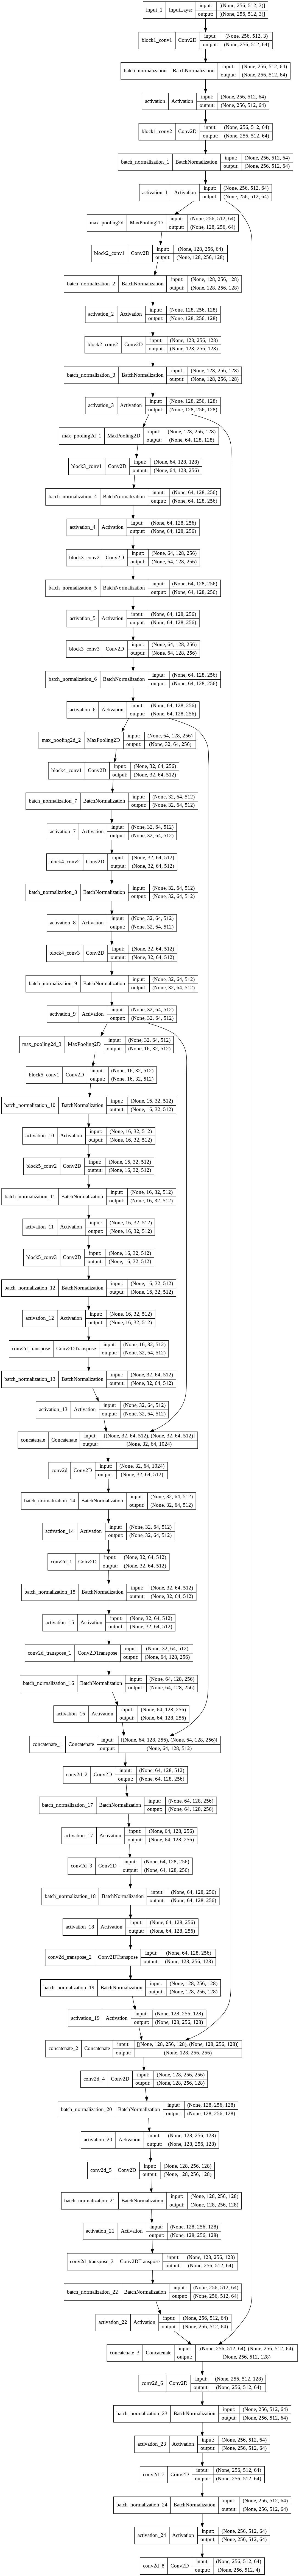

In [47]:
tf.keras.utils.plot_model(model, show_shapes= True)

## Model training

In [48]:
history = model.fit_generator(data_generator(dataset, batch_size, 'train'),
                              steps_per_epoch=160 // batch_size,
                              validation_data=data_generator(dataset, val_batch, 'val'),
                              validation_steps=20 // val_batch,
                              callbacks=[callback, reduce_lr,model_checkpoint],
                              epochs=100,
                              verbose=1)

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.7775 - dice_coef: 0.5635
Epoch 00001: val_dice_coef improved from inf to 0.41703, saving model to kitti-unet-semantic-model.h5
40/40 [==============================] - 70s 2s/step - loss: 0.7775 - dice_coef: 0.5635 - val_loss: 1.0172 - val_dice_coef: 0.4170 - lr: 1.0000e-04
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.3046 - dice_coef: 0.8199
Epoch 00002: val_dice_coef did not improve from 0.41703
40/40 [==============================] - 64s 2s/step - loss: 0.3046 - dice_coef: 0.8199 - val_loss: 0.8718 - val_dice_coef: 0.4924 - lr: 1.0000e-04
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.2212 - dice_coef: 0.8710
Epoch 00003: val_dice_coef did not improve from 0.41703
40/40 [==============================] - 64s 2s/step - loss: 0.2212 - dice_coef: 0.8710 - val_loss: 0.5870 - val_dice_coef: 0.6264 - lr: 1.0000e-04
Epoch 4/100
40/40 [==============================] - E

In [49]:
model.save('/content/drive/MyDrive/Đồ án khmt/CS406/kitti-unet-semantic-model.h5')

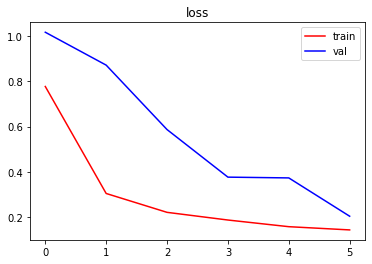

In [50]:
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")
plt.savefig('Unet_loss.png')

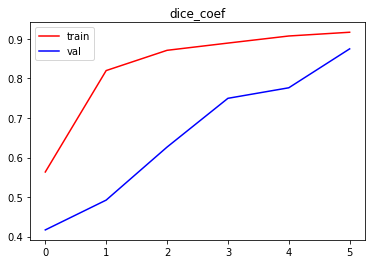

In [51]:
plt.gcf().clear()
plt.title("dice_coef")
plt.plot(history.history["dice_coef"], color="r", label="train")
plt.plot(history.history["val_dice_coef"], color="b", label="val")
plt.legend(loc="best")
plt.savefig('Unet_dice_coef.png')

# Testing

In [74]:
model = load_model('/content/drive/MyDrive/Đồ án khmt/CS406/kitti-unet-semantic-model.h5', custom_objects= {'dice_coef':dice_coef})

In [79]:
def pp(image):
    alpha = 0.6
    dims = image.shape
    x = cv2.resize(image, (512, 256))
    x = np.float32(x)/255.
    z = model.predict(np.expand_dims(x, axis=0))
    z = np.squeeze(z)
    z = z.reshape(256, 512, 4)
    z = cv2.resize(z, (dims[1], dims[0]))
    y = np.argmax(z, axis=2)
    
    img_color = image.copy()   
    for i in range(dims[0]):
        for j in range(dims[1]):
            img_color[i, j] = color_map[str(y[i, j])]
    cv2.addWeighted(image, alpha, img_color, 1-alpha, 0, img_color)
    return img_color

downloading https://cdn.motor1.com/images/mgl/lW2Jl/s1/qoros-5.jpg


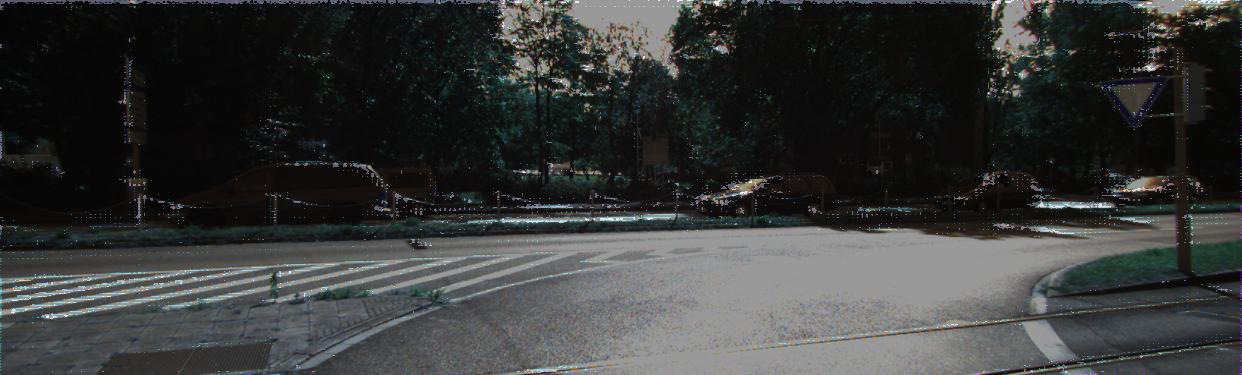

In [81]:
color_map = {
'0': [0, 0, 0],
 '1': [153, 153, 0],
 '2': [255, 204, 204],
 '3': [255, 0, 127],
 '4': [0, 255, 0],
 '5': [0, 204, 204],
 '6': [255, 0, 0],
 '7': [0, 0, 255]
}
from google.colab.patches import cv2_imshow
from skimage import io
url = "https://cdn.motor1.com/images/mgl/lW2Jl/s1/qoros-5.jpg"
print(f"downloading {url}")
img_sample = io.imread("/content/drive/MyDrive/Đồ án khmt/CS406/data_semantics/testing/image_2/000000_10.png")
cv2_imshow(pp(img_sample))

In [64]:
color_map = {
'0': [0, 0, 0],
 '1': [153, 153, 0],
 '2': [255, 204, 204],
 '3': [255, 0, 127],
 '4': [0, 255, 0],
 '5': [0, 204, 204],
 '6': [255, 0, 0],
 '7': [0, 0, 255]
}

s = time.time()
for t in tqdm.tqdm(range(len(image_list))):
    img = image.load_img(f'{test_dir}/{image_list[t]}')
    img = image.img_to_array(img)
    alpha = 0.6
    dims = img.shape
    x = cv2.resize(img, (256, 256))
    x = np.float32(x)/255.
    z = unet.predict(np.expand_dims(x, axis=0))
    z = np.squeeze(z)
    z = z.reshape(256, 256, 8)
    z = cv2.resize(z, (dims[1], dims[0]))
    y = np.argmax(z, axis=2)
    
    img_color = img.copy()   
    for i in range(dims[0]):
        for j in range(dims[1]):
            img_color[i, j] = color_map[str(y[i, j])]
    cv2.addWeighted(img, alpha, img_color, 1-alpha, 0, img_color)
    cv2.imwrite(f'outputs/stuggart02/{image_list[t]}', cv2.cvtColor(img_color, cv2.COLOR_RGB2BGR))   
e = time.time()
t = str(e-s)
o = str((e-s)/len(image_list))
print(f'total time taken = {t}')
print(f'time taken per image = {o}')

Predict Time: 299.968 ms


error: ignored

In [ ]:
vc = cv2.VideoCapture('./demo/stuttgart_02.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    vw_name = './demo/result_stuttgart_02.mp4'
    vw = cv2.VideoWriter(vw_name, fourcc, 30.0, (512, 256))

    t_start = cv2.getTickCount()
    config = tf.ConfigProto()
    # config.gpu_options.per_process_gpu_memory_fraction = 0.9
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

    with open(os.path.join(flag.ckpt_dir, flag.ckpt_name, 'model.json'), 'r') as json_file:
            loaded_model_json = json_file.read()
    model = model_from_json(loaded_model_json)
    weight_list = sorted(glob(os.path.join(flag.ckpt_dir, flag.ckpt_name, "weight*")))
    model.load_weights(weight_list[-1])
    print ("[*] model load : %s"%weight_list[-1])
    t_total = (cv2.getTickCount() - t_start) / cv2.getTickFrequency() * 1000 
    print ("[*] model loading Time: %.3f ms"%t_total)

    while True:
        # imgInput = cv2.imread(flag.test_image_path, 1)
        ok, imgInput = vc.read()
        if ok is False:
            break
        imgInput = cv2.cvtColor(imgInput, cv2.COLOR_BGR2RGB)
        input_data = imgInput.reshape((1,256,512,3)).astype(np.float32)

        t_start = cv2.getTickCount()
        result = model.predict(input_data, 1)
        t_total = (cv2.getTickCount() - t_start) / cv2.getTickFrequency() * 1000
        print ("Predict Time: %.3f ms"%t_total)
        
        imgMask = (result[0]*255).astype(np.uint8)
        # human, car, road
        _, imgMask[:,:,0] = cv2.threshold(imgMask[:,:,0], int(255*0.5), 255, cv2.THRESH_BINARY)
        _, imgMask[:,:,1] = cv2.threshold(imgMask[:,:,1], int(255*0.5), 255, cv2.THRESH_BINARY)
        _, imgMask[:,:,2] = cv2.threshold(imgMask[:,:,2], int(255*0.5), 255, cv2.THRESH_BINARY)
        imgShow = cv2.cvtColor(imgInput, cv2.COLOR_RGB2BGR)
        
        imgMaskColor = imgMask
        imgShow = cv2.addWeighted(imgShow, 0.5, imgMaskColor, 0.6, 0.0)

        cv2.imshow('show', imgShow)

In [ ]:
from skimage import io
url = "https://cdn.motor1.com/images/mgl/lW2Jl/s1/qoros-5.jpg"
print(f"downloading {url}")
img_sample = io.imread("/content/drive/MyDrive/Đồ án khmt/CS406/data_semantics/training/image_2/000006_10.png")
show_predictions(img_sample)